In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import os
import tensorflow as tf

In [2]:
import zipfile

data_r = zipfile.ZipFile('train.zip', 'r')
data_r.extractall()

In [3]:
data_r = zipfile.ZipFile('test.zip', 'r')
data_r.extractall()

In [2]:
def download_data(path):
  data = []
  for path_image in sorted(os.listdir(path=path)):
    image = Image.open(path + path_image) #Открываем изображение.
    data.append(np.array(image)) #Загружаем пиксели.
  return data

In [3]:
X_train = download_data(r"train/images/")
Y_train = download_data(r"train/masks/")
X_test = download_data(r"test/images/")
Y_test = download_data(r"test/masks/")


array([[[177, 181, 184],
        [205, 209, 212],
        [219, 222, 227],
        ...,
        [226, 229, 244],
        [230, 233, 250],
        [243, 246, 255]],

       [[217, 221, 224],
        [244, 248, 251],
        [252, 255, 255],
        ...,
        [229, 232, 247],
        [217, 220, 235],
        [208, 211, 226]],

       [[234, 238, 241],
        [252, 255, 255],
        [250, 253, 255],
        ...,
        [240, 242, 255],
        [237, 239, 252],
        [226, 228, 241]],

       ...,

       [[201, 198, 209],
        [221, 218, 229],
        [221, 215, 225],
        ...,
        [241, 234, 224],
        [255, 250, 240],
        [255, 251, 241]],

       [[194, 191, 202],
        [215, 212, 223],
        [223, 217, 227],
        ...,
        [222, 215, 205],
        [230, 223, 213],
        [223, 216, 206]],

       [[212, 209, 220],
        [195, 192, 203],
        [179, 173, 183],
        ...,
        [240, 233, 223],
        [255, 248, 238],
        [253, 246, 236]]], dtype=uint8)
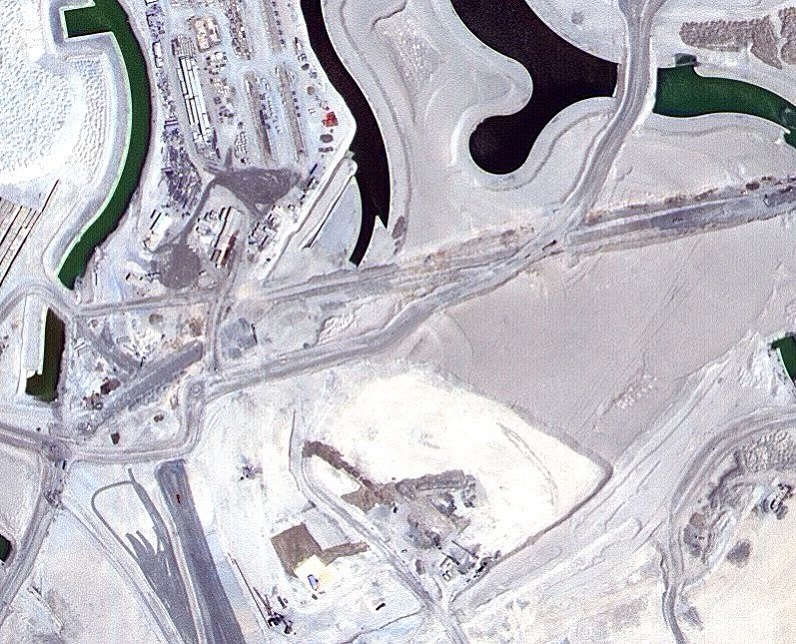

In [4]:
X_train[0]

In [5]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
   return input_image, input_mask

In [6]:
X_train, Y_train = resize(X_train, Y_train)

In [7]:
X_test, Y_test = resize(X_test, Y_test)

In [8]:
X_train[0]

<tf.Tensor: shape=(128, 128, 3), dtype=int32, numpy=
array([[[238, 241, 246],
        [185, 190, 196],
        [249, 255, 255],
        ...,
        [178, 177, 185],
        [220, 219, 225],
        [235, 237, 250]],

       [[254, 255, 255],
        [252, 255, 255],
        [250, 251, 253],
        ...,
        [213, 209, 223],
        [199, 192, 199],
        [152, 145, 152]],

       [[194, 194, 196],
        [239, 238, 243],
        [253, 254, 255],
        ...,
        [ 96,  88, 101],
        [157, 142, 149],
        [148, 132, 133]],

       ...,

       [[213, 207, 217],
        [238, 233, 239],
        [211, 208, 219],
        ...,
        [247, 240, 234],
        [218, 211, 203],
        [241, 234, 224]],

       [[231, 225, 235],
        [166, 161, 167],
        [211, 208, 219],
        ...,
        [255, 253, 250],
        [237, 230, 222],
        [223, 216, 208]],

       [[246, 240, 250],
        [198, 191, 198],
        [199, 197, 208],
        ...,
        [240, 237, 23

In [14]:
palette = {0 : (60, 16, 152), # Building
           1 : (132, 41, 246), # Land
           2 : (110, 193, 228), # Road
           3 : (254, 221, 58), # Vegetation
           4 : (226, 169, 41), # Water
           5 : (155, 155, 155)} # Unlabeled

In [15]:
invert_palette = {v: k for k, v in palette.items()}

In [11]:
# сегментация нейронной сети в RGB изображение
def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

NameError: name 'palette' is not defined

In [17]:
def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.int8) # принадлежность каждого пикселя классу
    min_distance = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.float32)+1000 # расстояние до ближайшего класса для пикселей
    for c, i in palette.items():
      distance = np.sum((arr_3d - np.array(c).reshape(1, 1, 3))**2, axis=-1)**(1/2) # ищем расстояние для каждого пикселя до проверяемого класса по евклиду рас-ие
      condition = min_distance > distance # поиск элементов меньше min_distance
      min_distance[condition] = distance[condition] # замена дистанции найденных элементов
      arr_2d[condition] = i # замена класса найденных элементов

    for c, i in palette.items():
      m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
      arr_2d[m] = i

    arr_2d = arr_2d.tolist()
    for i in range(len(arr_2d)):
      for j in range(len(arr_2d[0])):
        label = [0, 0, 0, 0, 0, 0]
        label[arr_2d[i][j]] = 1
        arr_2d[i][j] = label
    arr_2d = np.array(arr_2d)

    return arr_2d

In [18]:
X_train_pred = np.array(X_train).reshape([7, 128, 128, 3])/255
X_test_pred = np.array(X_test).reshape([2, 128, 128, 3])/255
Y_train_pred = []
for i in range(len(Y_train)):
  Y_train_pred.append(convert_from_color(Y_train[i][:, :, :3]))
Y_train_pred = np.array(Y_train_pred)
Y_test_pred = []
for i in range(len(Y_test)):
  Y_test_pred.append(convert_from_color(Y_test[i][:, :, :3]))
Y_test_pred = np.array(Y_test_pred)


In [30]:
X_train_pred[0]

array([[[0.93333333, 0.94509804, 0.96470588],
        [0.7254902 , 0.74509804, 0.76862745],
        [0.97647059, 1.        , 1.        ],
        ...,
        [0.69803922, 0.69411765, 0.7254902 ],
        [0.8627451 , 0.85882353, 0.88235294],
        [0.92156863, 0.92941176, 0.98039216]],

       [[0.99607843, 1.        , 1.        ],
        [0.98823529, 1.        , 1.        ],
        [0.98039216, 0.98431373, 0.99215686],
        ...,
        [0.83529412, 0.81960784, 0.8745098 ],
        [0.78039216, 0.75294118, 0.78039216],
        [0.59607843, 0.56862745, 0.59607843]],

       [[0.76078431, 0.76078431, 0.76862745],
        [0.9372549 , 0.93333333, 0.95294118],
        [0.99215686, 0.99607843, 1.        ],
        ...,
        [0.37647059, 0.34509804, 0.39607843],
        [0.61568627, 0.55686275, 0.58431373],
        [0.58039216, 0.51764706, 0.52156863]],

       ...,

       [[0.83529412, 0.81176471, 0.85098039],
        [0.93333333, 0.91372549, 0.9372549 ],
        [0.82745098, 0

In [3]:
import numpy as np
from keras import *
from keras.models import *
from keras.layers import *
from keras.optimizers import *

In [16]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

In [15]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

In [14]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

In [17]:
def build_unet_model():
   # inputs
   inputs = layers.Input(shape=(128,128,3))
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)
   # outputs
   outputs = layers.Conv2D(6, 1, padding="same", activation = "softmax")(u9)
   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model

In [18]:
unet_model = build_unet_model()

In [19]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="categorical_crossentropy",
                  metrics="accuracy")

In [26]:
%%time

history = unet_model.fit(X_train_pred, Y_train_pred,  epochs=10, validation_data = (X_test_pred, Y_test_pred))

Epoch 1/10
1/1 [==============================] - 19s 19s/step - loss: 1.6580 - accuracy: 0.2786 - val_loss: 1.0818 - val_accuracy: 0.6051
Epoch 2/10
1/1 [==============================] - 13s 13s/step - loss: 1.2994 - accuracy: 0.6270 - val_loss: 1.0614 - val_accuracy: 0.6051
Epoch 3/10
1/1 [==============================] - 14s 14s/step - loss: 1.0634 - accuracy: 0.6271 - val_loss: 1.0576 - val_accuracy: 0.6051
Epoch 4/10
1/1 [==============================] - 13s 13s/step - loss: 1.0458 - accuracy: 0.6271 - val_loss: 1.0500 - val_accuracy: 0.6051
Epoch 5/10
1/1 [==============================] - 13s 13s/step - loss: 1.0303 - accuracy: 0.6272 - val_loss: 1.0453 - val_accuracy: 0.6051
Epoch 6/10
1/1 [==============================] - 13s 13s/step - loss: 1.0224 - accuracy: 0.6272 - val_loss: 1.0448 - val_accuracy: 0.6051
Epoch 7/10
1/1 [==============================] - 13s 13s/step - loss: 1.0166 - accuracy: 0.6272 - val_loss: 1.0490 - val_accuracy: 0.6051
Epoch 8/10
1/1 [===========

По результатам первого обучения нейросети мы видим крайне противоречивые данные. Это как недостаточная эффективность предсказаний, так и стагнация val_accuracy. Первый вывод напрашивается сам собой и он говорит об ограниченности обучающего и тестового датасетов.

1/1 [==============================] - 16s 16s/step - loss: 1.0132 - accuracy: 0.6272 - val_loss: 1.0441 - val_accuracy: 0.6051
Epoch 9/10
1/1 [==============================] - 12s 12s/step - loss: 1.0091 - accuracy: 0.6272 - val_loss: 1.0226 - val_accuracy: 0.6051
Epoch 10/10
1/1 [==============================] - 12s 12s/step - loss: 1.0075 - accuracy: 0.6291 - val_loss: 1.0247 - val_accuracy: 0.6051
CPU times: user 3min 35s, sys: 10.2 s, total: 3min 45s
Wall time: 2min 26s

Но даже такая простая модель требует серьезных вычислительных мощностей и затрат времени. Попробуем настроить параметры нейросети для лучших результатов.


In [32]:
# metrics=[dice_coef]

def dice_bce_loss(y_pred, y_true):
    total_loss = 0.25 * dice_loss(y_pred, y_true) + tf.keras.losses.binary_crossentropy(y_pred, y_true)
    return total_loss

In [47]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
                  loss="mean_squared_error",
                  metrics='accuracy')

In [48]:
%%time

history = unet_model.fit(X_train_pred, Y_train_pred,  epochs=10, validation_data = (X_test_pred, Y_test_pred))

Epoch 1/10
1/1 [==============================] - 19s 19s/step - loss: 0.0967 - accuracy: 0.6273 - val_loss: 0.1043 - val_accuracy: 0.6051
Epoch 2/10
1/1 [==============================] - 13s 13s/step - loss: 0.0978 - accuracy: 0.6273 - val_loss: 0.1010 - val_accuracy: 0.6051
Epoch 3/10
1/1 [==============================] - 13s 13s/step - loss: 0.0958 - accuracy: 0.6273 - val_loss: 0.1000 - val_accuracy: 0.6051
Epoch 4/10
1/1 [==============================] - 13s 13s/step - loss: 0.0963 - accuracy: 0.6273 - val_loss: 0.0981 - val_accuracy: 0.6051
Epoch 5/10
1/1 [==============================] - 14s 14s/step - loss: 0.0951 - accuracy: 0.6273 - val_loss: 0.0978 - val_accuracy: 0.6051
Epoch 6/10
1/1 [==============================] - 13s 13s/step - loss: 0.0941 - accuracy: 0.6273 - val_loss: 0.0987 - val_accuracy: 0.6051
Epoch 7/10
1/1 [==============================] - 13s 13s/step - loss: 0.0943 - accuracy: 0.6273 - val_loss: 0.0981 - val_accuracy: 0.6051
Epoch 8/10
1/1 [===========

Мы ппровели несколько тестов с разными параметрами.

Epoch 9/10
1/1 [==============================] - 13s 13s/step - loss: 2.9162 - accuracy: 0.0130 - val_loss: 3.1179 - val_accuracy: 0.0179
Epoch 10/10
1/1 [==============================] - 13s 13s/step - loss: 2.9908 - accuracy: 0.0660 - val_loss: 2.3527 - val_accuracy: 0.1994
CPU times: user 3min 34s, sys: 8.81 s, total: 3min 43s
Wall time: 2min 26s

-------------------------------
Epoch 9/10
1/1 [==============================] - 13s 13s/step - loss: 1.3174 - accuracy: 0.6270 - val_loss: 1.3788 - val_accuracy: 0.6051
Epoch 10/10
1/1 [==============================] - 13s 13s/step - loss: 1.2843 - accuracy: 0.6272 - val_loss: 1.3309 - val_accuracy: 0.6051
CPU times: user 3min 33s, sys: 8.26 s, total: 3min 41s
Wall time: 2min 12s

-------------------------------
Epoch 9/10
1/1 [==============================] - 13s 13s/step - loss: 0.0927 - accuracy: 0.6273 - val_loss: 0.0959 - val_accuracy: 0.6051
Epoch 10/10
1/1 [==============================] - 13s 13s/step - loss: 0.0925 - accuracy: 0.6272 - val_loss: 0.0960 - val_accuracy: 0.6051
CPU times: user 3min 34s, sys: 7.5 s, total: 3min 42s
Wall time: 2min 27s

Очевидно что никаие изменения оптимизатора, функции потерь или скорости обчучения не помогут оптимизировать обучение данного типа нейросети при имеющемся малом датасете.
ПОпробуем исмользовать другой датасет.

In [4]:
import tensorflow_datasets as tfds
from IPython.display import clear_output

tfds.disable_progress_bar()

In [50]:
dataset, info = tfds.load('lost_and_found', with_info=True)

Dataset lost_and_found downloaded and prepared to /root/tensorflow_datasets/lost_and_found/semantic_segmentation/1.0.0. Subsequent calls will reuse this data.


In [5]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [6]:
@tf.function
def load_image_train(datapoint):
  for img in datapoint:
    input_image = tf.image.resize(datapoint['image_left'], (224, 224,), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_mask = tf.image.resize(datapoint['segmentation_label'], (224, 224), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    if tf.random.uniform(()) > 0.5:
      input_image = tf.image.flip_left_right(input_image)
      input_mask = tf.image.flip_left_right(input_mask)

    # input_image = normalize(input_image)

  return input_image , input_mask

In [7]:
@tf.function
def load_image_test(datapoint):
  for img in datapoint:
    input_image = tf.image.resize(datapoint['image_left'], (224, 224,), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_mask = tf.image.resize(datapoint['segmentation_label'], (224, 224), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    if tf.random.uniform(()) > 0.5:
      input_image = tf.image.flip_left_right(input_image)
      input_mask = tf.image.flip_left_right(input_mask)

    # input_image = normalize(input_image)

  return input_image , input_mask

In [8]:
import pandas as pd
row_lens = []
col_lens = []
for img in dataset['train']:
  row_lens.append(int(img['image_left'].shape[0]))
  col_lens.append(int(img['image_left'].shape[1]))
t = pd.DataFrame(row_lens, columns=['rows'])
t['cols'] = col_lens

NameError: name 'dataset' is not defined

In [55]:
images = []
for img in dataset['train']:
  single_img = img['image_left']
  images.append(single_img)

In [56]:
images[2].shape

TensorShape([1024, 2048, 3])

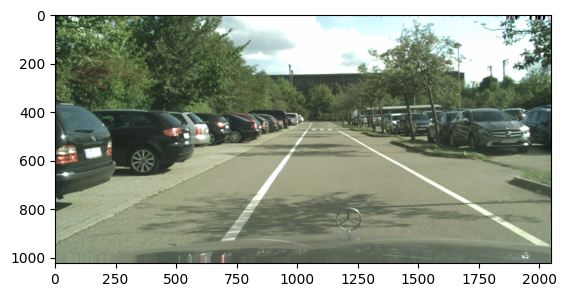

In [57]:
plt.imshow(images[2])
plt.show()

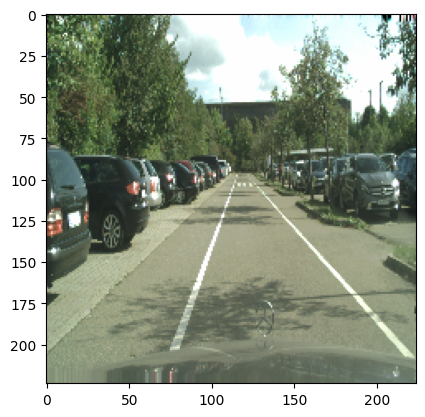

In [58]:
t = tf.image.resize(images[2], (224, 224, ), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
plt.imshow(t[:,:,:])
plt.show()

In [59]:
t.shape

TensorShape([224, 224, 3])

In [60]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 32
BUFFER_SIZE = 100
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [61]:
load_image_train
load_image_test

In [62]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [71]:
train

<_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(224, 224, 1), dtype=tf.uint8, name=None))>

In [63]:
train_ds = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test.batch(BATCH_SIZE)

In [67]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 224, 224, 1), dtype=tf.uint8, name=None))>

In [74]:
type(test_ds)

tensorflow.python.data.ops.batch_op._BatchDataset

In [68]:
model_2 = build_unet_model()

In [ ]:
model_2.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="categorical_crossentropy",
                  metrics="accuracy")

In [ ]:
%%time

history = train_ds.fit(X_train_pred, Y_train_pred,  epochs=10, validation_data = (X_test_pred, Y_test_pred))

In [75]:
def display_images(display_list):
  plt.figure(figsize=(15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[i][:,:,:])
    plt.axis('off')

plt.show()

In [1]:
for image in train.take(1):
	sample_image= image
	display_list = sample_image

display_images(display_list)

NameError: name 'train' is not defined

In [77]:
import os
import seaborn as sns
from tensorflow import keras
import cv2
import PIL
from IPython.display import clear_output

In [78]:
width, height = 224, 224

In [79]:
base_model = keras.applications.vgg16.VGG16(
    include_top=False, input_shape=(width, height, 3))

layer_names = [
    'block1_pool',
    'block2_pool',
    'block3_pool',
    'block4_pool',
    'block5_pool',
]
base_model_outputs = [base_model.get_layer(
    name).output for name in layer_names]
base_model.trainable = False

VGG_16 = tf.keras.models.Model(base_model.input,
                               base_model_outputs)

58889256/58889256 [==============================] - 0s 0us/step


In [80]:
def fcn8_decoder(convs, n_classes):
	f1, f2, f3, f4, p5 = convs

	n = 4096
	c6 = tf.keras.layers.Conv2D(
		n, (7, 7), activation='relu', padding='same',
	name="conv6")(p5)
	c7 = tf.keras.layers.Conv2D(
		n, (1, 1), activation='relu', padding='same',
	name="conv7")(c6)

	f5 = c7

	# upsample the output of the encoder
	# then crop extra pixels that were introduced
	o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(
		4, 4), strides=(2, 2), use_bias=False)(f5)
	o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

	# load the pool 4 prediction and do a 1x1
	# convolution to reshape it to the same shape of `o` above
	o2 = f4
	o2 = (tf.keras.layers.Conv2D(n_classes, (1, 1),
								activation='relu',
								padding='same'))(o2)

	# add the results of the upsampling and pool 4 prediction
	o = tf.keras.layers.Add()([o, o2])

	# upsample the resulting tensor of the operation you just did
	o = (tf.keras.layers.Conv2DTranspose(
		n_classes, kernel_size=(4, 4), strides=(2, 2),
	use_bias=False))(o)
	o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

	# load the pool 3 prediction and do a 1x1
	# convolution to reshape it to the same shape of `o` above
	o2 = f3
	o2 = (tf.keras.layers.Conv2D(n_classes, (1, 1),
								activation='relu',
								padding='same'))(o2)

	# add the results of the upsampling and pool 3 prediction
	o = tf.keras.layers.Add()([o, o2])

	# upsample up to the size of the original image
	o = tf.keras.layers.Conv2DTranspose(
		n_classes, kernel_size=(8, 8), strides=(8, 8),
	use_bias=False)(o)

	# append a softmax to get the class probabilities
	o = tf.keras.layers.Activation('softmax')(o)
	return o

In [ ]:
def segmentation_model():

	inputs = keras.layers.Input(shape=(width, height, 3))
	convs = VGG_16(inputs)
	outputs = fcn8_decoder(convs, 3)
	model = tf.keras.Model(inputs=inputs, outputs=outputs)

	return model


opt = keras.optimizers.Adam()

model = segmentation_model()
model.compile(optimizer=opt,
			loss=tf.keras.losses.SparseCategoricalCrossentropy(
				from_logits=True),
			metrics=['accuracy'])

В данном месте у нас явно не хватает выделенныз вычислительных мощностей и работать с датасетом из лекции в гугл коллабе не получится.
Попробуем использовать датасет меньшего размера.

In [ ]:
def create_mask(pred_mask):
	pred_mask = tf.argmax(pred_mask, axis=-1)
	pred_mask = pred_mask[..., tf.newaxis]
	return pred_mask[0]


# def show_predictions(dataset=None, num=1):
# 	if dataset:
# 		for image, mask in dataset.take(num):
# 			pred_mask = model.predict(image)
# 			display_images([image[0], mask[0], create_mask(pred_mask)])
# 	else:
# 		# display_images([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])
# 		display_images([sample_image, sample_image, create_mask(model.predict(sample_image[tf.newaxis, ...]))])


# show_predictions()

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_ds, epochs=EPOCHS,
						steps_per_epoch=STEPS_PER_EPOCH,
						validation_steps=VALIDATION_STEPS,
						validation_data=test_ds)


In [ ]:
def compute_metrics(y_true, y_pred):
	'''
	Computes IOU and Dice Score.

	Args:
	y_true (tensor) - ground truth label map
	y_pred (tensor) - predicted label map
	'''

	class_wise_iou = []++++++++++++++++++++++++++++++++++++++++++++++++++++
	class_wise_dice_score = []++++++++++++++++++++

	smoothening_factor = 0.00001

	for i in range(3):
		intersection = np.sum((y_pred == i) * (y_true == i))
		y_true_area = np.sum((y_true == i))++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++=+++++++++++++++++=+++++=+++++++++++++++++++++++++++++++++++++++
		y_pred_area = np.sum((y_pred == i))+++++++++++++++++++++
		iou = (intersection + smoothening_factor) / \++++++++++++++++++++++++++++++++++++
			(combined_area - intersection + smoothening_factor)
		class_wise_iou.append(iou)

		dice_score = 2 * ((intersection + smoothening_factor) /
						(combined_area + smoothening_factor))
		class_wise_dice_score.append(dice_score)

	9+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++return class_wise_iou, class_wise_dice_score


In [ ]:
def get_test_image_and_annotation_arrays():
	'''
	Unpacks the test dataset and returns
	the input images and segmentation masks
	'''

	ds = test_ds.unbatch()
	ds = ds.batch(info.splits['test'].num_examples)

	images = []
	y_true_segments = []

	for image, annotation in ds.take(1):
		y_true_segments = annotation.numpy()
		images = image.numpy()

	y_true_segments = y_true_segments[:(
		info.splits['test'].num_examples - (info.splits['test']
											.num_examples % BATCH_SIZE))]
	images = images[:(info.splits['test'].num_examples -
					(info.splits['test'].num_examples % BATCH_SIZE))]

	return images, y_true_segments


y_true_images, y_true_segments = get_test_image_and_annotation_arrays()

integer_slider = 2574
img = np.reshape(y_true_images[integer_slider], (1, width, height, 3))
y_pred_mask = model.predict(img)
y_pred_mask = create_mask(y_pred_mask)
y_pred_mask.shape


def display_prediction(display_list, display_string):
	plt.figure(figsize=(15, 15))
	title = ['Input Image', 'True Mask', 'Predicted Mask']

	for i in range(len(display_list)):
		plt.subplot(1, len(display_list), i+1)
		plt.title(title[i])
		plt.xticks([])
		plt.yticks([])
		if i == 1:
			plt.xlabel(display_string, fontsize=12)
		plt.imshow(keras.preprocessing.image.array_to_img(display_list[i]))
	plt.show()


iou, dice_score = compute_metrics(
	y_true_segments[integer_slider], y_pred_mask.numpy())
display_list = [y_true_images[integer_slider],
				y_true_segments[integer_slider], y_pred_mask]

display_string_list = ["{}: IOU: {} Dice Score: {}".format(display_list[idx],
														i, dc) for idx, (i, dc) in
					enumerate(zip(np.round(iou, 4), np.round(dice_score, 4)))]
display_string = "\n\n".join(display_string_list)


# showing predictions with metrics
display_prediction(display_list, display_string)


Попробуем в качестве датасета использовать данные Северстали из предвдущих занятий.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout

In [21]:
data = pd.read_csv('train_csv.csv')

In [22]:
data

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
...,...,...,...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...


In [23]:
data.shape

(7095, 3)

In [24]:
import cv2

In [25]:
!unzip "train_images.zip" -d "train_images"

Archive:  train_images.zip
  inflating: train_images/f00185797.jpg  
  inflating: train_images/f0074b888.jpg  
  inflating: train_images/f0075e43c.jpg  
  inflating: train_images/f024c4789.jpg  
  inflating: train_images/f03379160.jpg  
  inflating: train_images/f0344b3ad.jpg  
  inflating: train_images/f035b1e71.jpg  
  inflating: train_images/f0437a9c3.jpg  
  inflating: train_images/f046dc5fa.jpg  
  inflating: train_images/f061c7c53.jpg  
  inflating: train_images/f0625054e.jpg  
  inflating: train_images/f07399cf6.jpg  
  inflating: train_images/f07969848.jpg  
  inflating: train_images/f0859ea87.jpg  
  inflating: train_images/f08716423.jpg  
  inflating: train_images/f10768627.jpg  
  inflating: train_images/f10e66f64.jpg  
  inflating: train_images/f10f625fd.jpg  
  inflating: train_images/f1119e073.jpg  
  inflating: train_images/f11471db2.jpg  
  inflating: train_images/f114d1a28.jpg  
  inflating: train_images/f11d59e33.jpg  
  inflating: train_images/f12206185.jpg  
  infla

In [40]:
l1=[]
l2=[]
for img,ClassId,EncodedPixels in tqdm(data.values):
    try:
      image=cv2.imread("train_images/{}".format(img),cv2.IMREAD_COLOR)
      image = cv2.resize(image,(128,128))
      l1.append(image)
      l2.append(ClassId)
    except:
      continue

100%|██████████| 7095/7095 [00:06<00:00, 1130.63it/s]


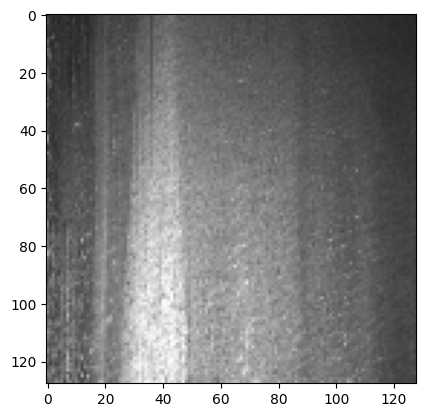

In [41]:
i = 15
plt.imshow(l1[i])

In [42]:
encoder = LabelEncoder()

X= np.array(l1)
X = X/255

y = encoder.fit_transform(l2)
y = np.array(y)

In [43]:
from imblearn.over_sampling import RandomOverSampler
reshaped_X = X.reshape(X.shape[0],-1)
oversample = RandomOverSampler(sampling_strategy='not majority')
X, y  = oversample.fit_resample(reshaped_X , y)
X = X.reshape(-1,128,128,3)

In [44]:
y = to_categorical(y)

In [45]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,shuffle=True)

In [46]:
def build_unet_model_st():
   # inputs
   inputs = layers.Input(shape=(128,128,3))
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)
   # outputs
   outputs = layers.Conv2D(6, 1, padding="same", activation = "softmax")(u9)
   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model

In [47]:
model_st = build_unet_model_st()

In [48]:
model_st.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="categorical_crossentropy",
                  metrics="accuracy")

In [49]:
%%time

history = model_st.fit(X_train, y_train,  epochs=10, validation_data = (X_test, y_test))

Epoch 1/10


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 4) and (None, 128, 128, 6) are incompatible


Здесь мы сталкиваемся с проблемой несовместимости арзитектуры нашей нейросети и данных датасета. Нейросеть написана на выявление 6 сегментов, а в датасете есть только 4 компонента.
Здесь мы возвращаемся на этап первичного конструирования нейросети под конкретную задачу, но не имея точных данных о том как формировался и размечался наш датасет сделать это будет практически невозможно.
На этом этапе приостановим наше знакомство с U-net нейросетями.